In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpplot as gpp
from poola import core as pool
import anchors
from adjustText import adjust_text

import core_functions as fns

gpp.set_aesthetics(palette='Set2')

In [26]:
def run_guide_residuals(lfc_df, paired_lfc_cols=[]):
    '''
    Calls get_guide_residuals function from anchors package to calculate guide-level residual z-scores
    Inputs:
    1. lfc_df: data frame with log-fold changes (relative to pDNA)
    2. paired_lfc_cols: grouped list of initial populations and corresponding resistant populations 
    
    '''
    lfc_df = lfc_df.drop_duplicates()
    if not paired_lfc_cols:
        paired_lfc_cols = fns.pair_cols(lfc_df)[1] #get lfc pairs 
    modified = []
    unperturbed = []
    #reference_df: column1 = modifier condition, column2 = unperturbed column
    ref_df = pd.DataFrame(columns=['modified', 'unperturbed'])
    row = 0 #row index for reference df 
    for pair in paired_lfc_cols:
        #number of resistant pops in pair = len(pair)-1
        res_idx = 1 
        #if multiple resistant populations, iterate 
        while res_idx < len(pair): 
            ref_df.loc[row, 'modified'] = pair[res_idx]
            ref_df.loc[row, 'unperturbed'] = pair[0]
            res_idx +=1 
            row +=1
    
    print(ref_df)
    #input lfc_df, reference_df 
    #guide-level
    residuals_lfcs, all_model_info, model_fit_plots = anchors.get_guide_residuals(lfc_df, ref_df)
    return residuals_lfcs, all_model_info, model_fit_plots

def select_top_ranks(df, rank = 5): #pick top ranks from each column of df with ranks, rank = top rank threshold (e.g. 5 if top 5)
    '''
    Inputs: 
    1. df: Dataframe with columns "Gene Symbol" and data used to rank 
    2. rank: top number of rows to select 
    Outputs:
    1. final_top_rank_df: Data frame with top ranked rows 
    '''
    rank_cols = df.columns.to_list()[1:]
    prev_top_rank_rows = pd.DataFrame(columns = df.columns)
    final_top_rank_df = pd.DataFrame() #for final list
    for col in rank_cols:
        #top_rank_rows = df.copy().loc[lambda df: df[col] <= rank, :] #pick rows with rank <= 5
        top_rank_rows = df.copy().nlargest(rank, col)
        top_rank_df = pd.concat([prev_top_rank_rows, top_rank_rows]) #concat with rows selected from previous column
        prev_top_rank_rows = top_rank_df #set combined list as previous

    final_top_rank_df = prev_top_rank_rows.drop_duplicates(subset = ['Gene Symbol']) #drop duplicate gene rows
    return final_top_rank_df


## Data summary
 

In [4]:
reads_1 = pd.read_csv('../../../Data/Reads/Goujon/Calu3/Brunello/counts-JD_GPP2726_Goujon_Plate3.txt', sep='\t')
reads_1 = reads_1.copy().drop('Construct IDs', axis=1)

# get pDNA reads from Sanson et al., 2018
pDNA_reads = pd.read_excel('../../../Data/Interim/Goujon/Calu3/Brunello/SansonetalSuppData1.xlsx', header=2)
pDNA_reads = pDNA_reads.copy().rename(columns={'sgRNA Sequence': 'Construct Barcode'})

reads = pd.merge(pDNA_reads[['Construct Barcode', 'pDNA']], reads_1, how = 'right', on ='Construct Barcode')
reads = reads.copy().drop(['EMPTY', 'Calu3-Brunello-MX1-initial population screen #2'], axis = 1)
reads

,Construct Barcode,pDNA,Calu3-Brunello-intitial population screen #1,Calu3-Brunello-resistant population screen #1,Calu3-Brunello-initial population screen #2,Calu3-Brunello-resistant population screen #2
0,AAAAAAAATCCGGACAATGG,522,576,2,342,1
1,AAAAAAAGGATGGTGATCAA,511,676,9,418,16
2,AAAAAAATGACATTACTGCA,467,613,0,436,0
3,AAAAAAATGTCAGTCGAGTG,200,245,1,187,8
4,AAAAAACACAAGCAAGACCG,286,366,1,136,283
...,...,...,...,...,...,...
77436,TTTGTTTGGATTGCTTCAAG,514,437,0,407,1
77437,TTTTACCTTGTTCACATGGA,828,1363,1,895,3525
77438,TTTTGACTCTAATCACCGGT,588,987,1,490,138
77439,TTTTTAATACAAGGTAATCT,503,861,10,313,16


In [5]:
# Gene Annotations
chip = pd.read_csv('../../../Data/Interim/Goujon/Calu3/Brunello/CP0041_GRCh38_NCBI_strict_gene_20210113.chip', sep='\t')
chip = chip.rename(columns={'Barcode Sequence':'Construct Barcode'})
chip_reads = pd.merge(chip[['Construct Barcode', 'Gene Symbol']], reads, on = ['Construct Barcode'], how = 'right')
chip_reads



,Construct Barcode,Gene Symbol,pDNA,Calu3-Brunello-intitial population screen #1,Calu3-Brunello-resistant population screen #1,Calu3-Brunello-initial population screen #2,Calu3-Brunello-resistant population screen #2
0,AAAAAAAATCCGGACAATGG,SLC25A24,522,576,2,342,1
1,AAAAAAAGGATGGTGATCAA,FASTKD3,511,676,9,418,16
2,AAAAAAATGACATTACTGCA,BCAS2,467,613,0,436,0
3,AAAAAAATGTCAGTCGAGTG,GPR18,200,245,1,187,8
4,AAAAAACACAAGCAAGACCG,ZNF470,286,366,1,136,283
...,...,...,...,...,...,...,...
86978,TTTTGACTCTAATCACCGGT,INACTIVE_4T_54,588,987,1,490,138
86979,TTTTTAATACAAGGTAATCT,NO_SITE_940,503,861,10,313,16
86980,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55,503,861,10,313,16
86981,TTTTTCTCACCCGATGAATC,NO_SITE_941,661,1199,4,673,161


In [6]:
#Calculate lognorm
cols = chip_reads.columns[2:].to_list() #reads columns = start at 3rd column
lognorms = fns.get_lognorm(chip_reads.dropna(), cols = cols)
lognorms

,Construct Barcode,Gene Symbol,pDNA_lognorm,Calu3-Brunello-intitial population screen #1_lognorm,Calu3-Brunello-resistant population screen #1_lognorm,Calu3-Brunello-initial population screen #2_lognorm,Calu3-Brunello-resistant population screen #2_lognorm
0,AAAAAAAATCCGGACAATGG,SLC25A24,4.044396,3.829569,0.442499,3.609648,0.036885
1,AAAAAAAGGATGGTGATCAA,FASTKD3,4.015550,4.045434,1.386978,3.877504,0.500133
2,AAAAAAATGACATTACTGCA,BCAS2,3.894030,3.913250,0.000000,3.934272,0.000000
3,AAAAAAATGTCAGTCGAGTG,GPR18,2.794666,2.727249,0.238149,2.833468,0.271631
4,AAAAAACACAAGCAAGACCG,ZNF470,3.246765,3.232424,0.238149,2.448008,3.058093
...,...,...,...,...,...,...,...
86978,TTTTGACTCTAATCACCGGT,INACTIVE_4T_54,4.206314,4.563664,0.238149,4.092287,2.193367
86979,TTTTTAATACAAGGTAATCT,NO_SITE_940,3.994203,4.375527,1.482735,3.492723,0.500133
86980,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55,3.994203,4.375527,1.482735,3.492723,0.500133
86981,TTTTTCTCACCCGATGAATC,NO_SITE_941,4.366491,4.833546,0.780657,4.526928,2.369979


## Quality Control
### Population Distributions

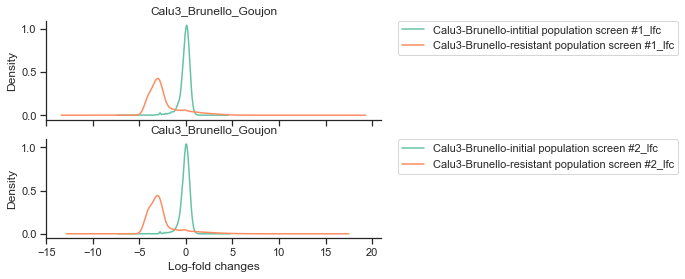

In [7]:
#Calculate log-fold change relative to pDNA
target_cols = list(lognorms.columns[3:])
pDNA_lfc = fns.calculate_lfc(lognorms,target_cols)
pDNA_lfc

pair_1 = [col for col in pDNA_lfc.columns if '#1' in col]
screen2_cols = [col for col in pDNA_lfc.columns if '#2' in col]
# pair_2 = screen2_cols[0:2]
# pair_3 = [screen2_cols[2],screen2_cols[1]]
paired_cols = (True, [pair_1, screen2_cols])

#Plot population distributions of log-fold changes 
fns.lfc_dist_plot(pDNA_lfc, paired_cols = paired_cols, filename = 'Calu3_Brunello_Goujon')


### ROC_AUC

Essential gene set: Hart et al., 2015 <br>
Non-essential gene set: Hart et al., 2014 <br>

Text(0, 0.5, 'True Positive Rate (essential)')

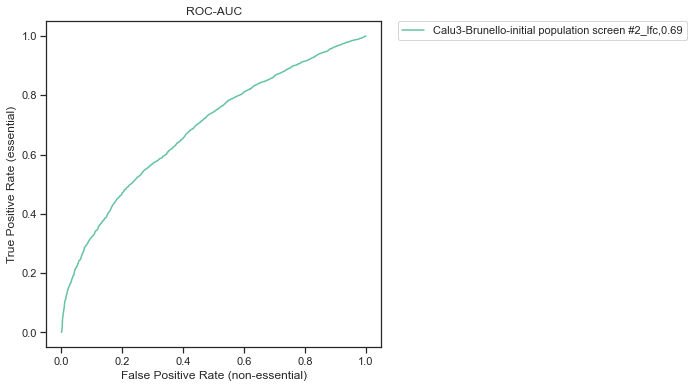

In [10]:
ess_genes, non_ess_genes = fns.get_gene_sets()
initial_cols = [col for col in pDNA_lfc.columns if 'initial' in col]

tp_genes = ess_genes.loc[:, 'Gene Symbol'].to_list()

fp_genes = non_ess_genes.loc[:, 'Gene Symbol'].to_list()

initial_roc_dict = {}
intial_roc_auc_dict = {}
for col in initial_cols:
    roc_auc, roc_df = pool.get_roc_aucs(pDNA_lfc, tp_genes, fp_genes, gene_col = 'Gene Symbol', score_col=col)
    initial_roc_dict[col] = roc_df
    intial_roc_auc_dict[col] = roc_auc

fig,ax=plt.subplots(figsize=(6,6))

for key, df in initial_roc_dict.items():
    roc_auc = intial_roc_auc_dict[key]
    ax=sns.lineplot(data=df, x='fpr',y='tpr', ci=None, label = key+',' + str(round(roc_auc,2)))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ROC-AUC')
plt.xlabel('False Positive Rate (non-essential)')
plt.ylabel('True Positive Rate (essential)')


## Gene level analysis

### Residual z-scores

In [11]:
lfc_df = pDNA_lfc.drop('Gene Symbol', axis = 1)
lfc_df

,Construct Barcode,Calu3-Brunello-intitial population screen #1_lfc,Calu3-Brunello-resistant population screen #1_lfc,Calu3-Brunello-initial population screen #2_lfc,Calu3-Brunello-resistant population screen #2_lfc
0,AAAAAAAATCCGGACAATGG,-0.214826,-3.601897,-0.434748,-4.007511
1,AAAAAAAGGATGGTGATCAA,0.029884,-2.628572,-0.138046,-3.515417
2,AAAAAAATGACATTACTGCA,0.019220,-3.894030,0.040242,-3.894030
3,AAAAAAATGTCAGTCGAGTG,-0.067418,-2.556518,0.038802,-2.523035
4,AAAAAACACAAGCAAGACCG,-0.014341,-3.008616,-0.798757,-0.188672
...,...,...,...,...,...
86978,TTTTGACTCTAATCACCGGT,0.357350,-3.968166,-0.114027,-2.012948
86979,TTTTTAATACAAGGTAATCT,0.381324,-2.511468,-0.501481,-3.494070
86980,TTTTTAATACAAGGTAATCT,0.381324,-2.511468,-0.501481,-3.494070
86981,TTTTTCTCACCCGATGAATC,0.467055,-3.585835,0.160436,-1.996513


In [12]:
# run_guide_residuals(lfc_df.drop_duplicates(), cols)
residuals_lfcs, all_model_info, model_fit_plots = run_guide_residuals(lfc_df, paired_lfc_cols=paired_cols[1])
residuals_lfcs


                                            modified  \
0  Calu3-Brunello-resistant population screen #1_lfc   
1  Calu3-Brunello-resistant population screen #2_lfc   

                                        unperturbed  
0  Calu3-Brunello-intitial population screen #1_lfc  
1   Calu3-Brunello-initial population screen #2_lfc  


,Construct Barcode,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCCGGACAATGG,Calu3-Brunello-resistant population screen #1_lfc,-1.099615,-0.608823,Calu3-Brunello-intitial population screen #1_lfc,-3.601897,-0.214826
1,AAAAAAAGGATGGTGATCAA,Calu3-Brunello-resistant population screen #1_lfc,-0.282788,-0.156571,Calu3-Brunello-intitial population screen #1_lfc,-2.628572,0.029884
2,AAAAAAATGACATTACTGCA,Calu3-Brunello-resistant population screen #1_lfc,-1.541188,-0.853308,Calu3-Brunello-intitial population screen #1_lfc,-3.894030,0.019220
3,AAAAAAATGTCAGTCGAGTG,Calu3-Brunello-resistant population screen #1_lfc,-0.147373,-0.081596,Calu3-Brunello-intitial population screen #1_lfc,-2.556518,-0.067418
4,AAAAAACACAAGCAAGACCG,Calu3-Brunello-resistant population screen #1_lfc,-0.633763,-0.350895,Calu3-Brunello-intitial population screen #1_lfc,-3.008616,-0.014341
...,...,...,...,...,...,...,...
154877,TTTGTTTGGATTGCTTCAAG,Calu3-Brunello-resistant population screen #2_lfc,-1.319502,-0.751258,Calu3-Brunello-initial population screen #2_lfc,-3.986589,-0.181794
154878,TTTTACCTTGTTCACATGGA,Calu3-Brunello-resistant population screen #2_lfc,4.367643,2.486715,Calu3-Brunello-initial population screen #2_lfc,1.850730,0.245306
154879,TTTTGACTCTAATCACCGGT,Calu3-Brunello-resistant population screen #2_lfc,0.631237,0.359394,Calu3-Brunello-initial population screen #2_lfc,-2.012948,-0.114027
154880,TTTTTAATACAAGGTAATCT,Calu3-Brunello-resistant population screen #2_lfc,-0.695611,-0.396046,Calu3-Brunello-initial population screen #2_lfc,-3.494070,-0.501481


In [13]:
guide_mapping = pool.group_pseudogenes(chip[['Construct Barcode', 'Gene Symbol']], pseudogene_size=4, gene_col='Gene Symbol', control_regex=['ONE_INTERGENIC','NO_SITE'])
guide_mapping


,Construct Barcode,Gene Symbol
0,AAAAAAAATCCGGACAATGG,SLC25A24
1,AAAAAAAGGATGGTGATCAA,FASTKD3
2,AAAAAAATGACATTACTGCA,BCAS2
3,AAAAAAATGTCAGTCGAGTG,GPR18
4,AAAAAACACAAGCAAGACCG,ZNF470
...,...,...
86978,TTTTGACTCTAATCACCGGT,INACTIVE_4T_54
86979,TTTTTAATACAAGGTAATCT,NO_SITE_184
86980,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55
86981,TTTTTCTCACCCGATGAATC,NO_SITE_115


In [14]:
gene_residuals = anchors.get_gene_residuals(residuals_lfcs.drop_duplicates(), guide_mapping)
gene_residuals

,condition,Gene Symbol,guides,avg_lfc,avg_lfc_reference,residual_zscore,p_value,fdr_bh
0,Calu3-Brunello-resistant population screen #1_lfc,A1BG,4,-2.937820,-0.016422,-0.625213,0.531831,0.983462
1,Calu3-Brunello-resistant population screen #1_lfc,A1CF,4,-2.739184,0.097927,-0.496055,0.619855,0.983462
2,Calu3-Brunello-resistant population screen #1_lfc,A2M,4,-2.588789,-0.146591,-0.148333,0.882080,0.992084
3,Calu3-Brunello-resistant population screen #1_lfc,A2ML1,4,-3.466996,0.253364,-1.426477,0.153731,0.983462
4,Calu3-Brunello-resistant population screen #1_lfc,A3GALT2,4,-3.378847,0.193924,-1.298740,0.194033,0.983462
...,...,...,...,...,...,...,...,...
41829,Calu3-Brunello-resistant population screen #2_lfc,ZYG11A,4,-2.999759,-0.220147,-0.348339,0.727586,0.995488
41830,Calu3-Brunello-resistant population screen #2_lfc,ZYG11B,4,-3.277642,-0.008051,-0.787747,0.430845,0.995488
41831,Calu3-Brunello-resistant population screen #2_lfc,ZYX,4,-1.549843,0.188247,1.040139,0.298275,0.995488
41832,Calu3-Brunello-resistant population screen #2_lfc,ZZEF1,4,-3.498973,0.160818,-1.101085,0.270860,0.995488


In [15]:
gene_residual_sheet = fns.format_gene_residuals(gene_residuals, guide_min = 3, guide_max = 5)

guide_residual_sheet = pd.merge(guide_mapping, residuals_lfcs.drop_duplicates(), on = 'Construct Barcode', how = 'inner')
guide_residual_sheet

['Calu3-Brunello-resistant population screen #1_lfc', 'Calu3-Brunello-resistant population screen #2_lfc']
Calu3-Brunello-resistant population screen #1_lfc
Calu3-Brunello-resistant population screen #2_lfc


,Construct Barcode,Gene Symbol,condition,residual,residual_z,unperturbed,lfc,lfc_reference
0,AAAAAAAATCCGGACAATGG,SLC25A24,Calu3-Brunello-resistant population screen #1_lfc,-1.099615,-0.608823,Calu3-Brunello-intitial population screen #1_lfc,-3.601897,-0.214826
1,AAAAAAAATCCGGACAATGG,SLC25A24,Calu3-Brunello-resistant population screen #2_lfc,-1.237324,-0.704470,Calu3-Brunello-initial population screen #2_lfc,-4.007511,-0.434748
2,AAAAAAAGGATGGTGATCAA,FASTKD3,Calu3-Brunello-resistant population screen #1_lfc,-0.282788,-0.156571,Calu3-Brunello-intitial population screen #1_lfc,-2.628572,0.029884
3,AAAAAAAGGATGGTGATCAA,FASTKD3,Calu3-Brunello-resistant population screen #2_lfc,-0.863535,-0.491653,Calu3-Brunello-initial population screen #2_lfc,-3.515417,-0.138046
4,AAAAAAATGACATTACTGCA,BCAS2,Calu3-Brunello-resistant population screen #1_lfc,-1.541188,-0.853308,Calu3-Brunello-intitial population screen #1_lfc,-3.894030,0.019220
...,...,...,...,...,...,...,...,...
173961,TTTTTAATACAAGGTAATCT,INACTIVE_5T_55,Calu3-Brunello-resistant population screen #2_lfc,-0.695611,-0.396046,Calu3-Brunello-initial population screen #2_lfc,-3.494070,-0.501481
173962,TTTTTCTCACCCGATGAATC,NO_SITE_115,Calu3-Brunello-resistant population screen #1_lfc,-1.568310,-0.868325,Calu3-Brunello-intitial population screen #1_lfc,-3.585835,0.467055
173963,TTTTTCTCACCCGATGAATC,NO_SITE_115,Calu3-Brunello-resistant population screen #2_lfc,0.564845,0.321594,Calu3-Brunello-initial population screen #2_lfc,-1.996513,0.160436
173964,TTTTTCTCACCCGATGAATC,INACTIVE_5T_56,Calu3-Brunello-resistant population screen #1_lfc,-1.568310,-0.868325,Calu3-Brunello-intitial population screen #1_lfc,-3.585835,0.467055


In [16]:
with pd.ExcelWriter('../../../Data/Processed/GEO_submission_v2/Calu3_Brunello_Goujon_influenzaA_v1.xlsx') as writer:  
    gene_residual_sheet.to_excel(writer, sheet_name='Calu3_avg_zscore', index =False)
    reads.to_excel(writer, sheet_name='Calu3_genomewide_reads', index =False)
    guide_mapping.to_excel(writer, sheet_name='Calu3_guide_mapping', index =False)

In [17]:
with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Calu3_Brunello_Goujon_influenzaA_v1.xlsx') as writer:  
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)

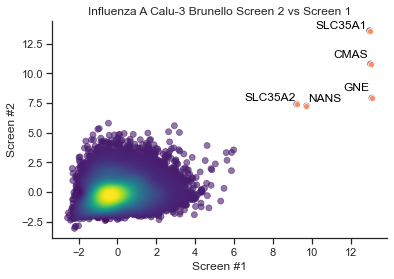

In [29]:
screen1_df = gene_residuals[gene_residuals['condition'].str.contains('#1')]
screen2_df = gene_residuals[gene_residuals['condition'].str.contains('#2')]

zscore_df = pd.merge(screen1_df[['Gene Symbol', 'residual_zscore']], screen2_df[['Gene Symbol', 'residual_zscore']], on = 'Gene Symbol', how = 'outer', suffixes = ['_screen#1', '_screen#2'])

zscore_annot_df = select_top_ranks(zscore_df)
fig, ax = plt.subplots()
ax = gpp.point_densityplot(zscore_df.dropna(), x='residual_zscore_screen#1', y='residual_zscore_screen#2')
sns.scatterplot(data=zscore_annot_df.dropna(), x='residual_zscore_screen#1', y='residual_zscore_screen#2')
texts= []
for j, row in zscore_annot_df.dropna().iterrows():
    texts.append(ax.text(row['residual_zscore_screen#1'], row['residual_zscore_screen#2'], row['Gene Symbol'], 
                                  color = 'black'))
        # ensures text labels are non-overlapping
    adjust_text(texts)
sns.despine()
plt.title('Influenza A Calu-3 Brunello Screen 2 vs Screen 1')
plt.xlabel('Screen #1')
plt.ylabel('Screen #2')
fig.savefig('../../../Figures/InfluenzaAScreen2vs1.png', bbox_inches='tight')



In [34]:
with pd.ExcelWriter('../../../Data/Processed/Individual_screens_v2/Calu3_Brunello_Goujon_influenzaA_indiv_screen_v1.xlsx') as writer:  
    zscore_df.to_excel(writer, sheet_name='indiv_screen_genomewide_zscore', index =False)
    gene_residuals.to_excel(writer, sheet_name='condition_genomewide_zscore', index =False)
    guide_residual_sheet.to_excel(writer, sheet_name='guide-level_zscore', index =False)